# BackTrader Examples

## What is Algorithmic Trading?
Algorithmic trading (also called algo trading) refers to using computer programs to execute trading strategies according to predefined rules. Instead of manually making trading decisions, you define a set of conditions and let the algorithm automatically place trades when those conditions are met.

## What is Backtrader?
Backtrader is a Python framework that allows you to:
- Develop trading strategies
- Backtest them on historical data
- Analyze performance
- Visualize results

Let's start building our first strategy step by step.

In [5]:
import backtrader as bt
import datetime
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# NOTE: Backtrader requires these libraries for creating and testing strategies
# bt is the main backtrader module
# yfinance helps us download historical market data
# pandas is for data manipulation
# matplotlib helps with plotting results

## Step 1: Define a Trading Strategy

We'll implement a Simple Moving Average (SMA) Crossover Strategy, which is a fundamental and widely used technical analysis strategy.

Concept: This strategy generates buy signals when a faster moving average crosses above a slower moving average, and sell signals when the faster moving average crosses below the slower moving average.

In [14]:
# Create a strategy
class SmaCrossStrategy(bt.Strategy):
    # Strategy parameters - these can be changed when we add the strategy to cerebro
    params = (
        ('fast_length', 10),  # fast moving average period (10 days)
        ('slow_length', 30),  # slow moving average period (30 days)
    )

    def log(self, txt, dt=None):
        """Logging function for the strategy"""
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')
        
    # NOTE: The __init__ method is called at the beginning of the backtest
    # It's where we set up indicators and initialize variables
    def __init__(self):
        # Keep track of close prices for our signals
        self.data_close = self.datas[0].close
        
        # Create moving averages
        # NOTE: SMA stands for Simple Moving Average - the average price over a period
        self.fast_ma = bt.indicators.SMA(self.datas[0], period=self.params.fast_length)
        self.slow_ma = bt.indicators.SMA(self.datas[0], period=self.params.slow_length)
        
        # Create a crossover signal
        # NOTE: CrossOver generates: +1 when fast crosses above slow, -1 when fast crosses below slow
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)
        
        # To keep track of pending orders
        self.order = None
        
        # Add trade analytics
        self.trade_count = 0
        self.profitable_trades = 0

    # NOTE: This method is called whenever an order status changes
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - no action required
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            else:
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None

    # NOTE: This method is called whenever a trade is completed
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
            
        self.trade_count += 1
        if trade.pnl > 0:
            self.profitable_trades += 1
            
        self.log(f'TRADE COMPLETED, PROFIT: {trade.pnl:.2f}, NET: {trade.pnlcomm:.2f}')
        # NOTE: pnl is gross profit/loss, pnlcomm is net profit/loss after commission

    # NOTE: The next method is called for each bar (candle) in our data
    # This is where we make trading decisions based on our strategy
    def next(self):
        # Skip if an order is pending
        if self.order:
            return
            
        # If not in the market and fast crosses above slow (bullish signal)
        if not self.position and self.crossover > 0:
            self.log(f'BUY CREATE, {self.data_close[0]:.2f}')
            self.order = self.buy()  # Place a buy order
        
        # If in the market and fast crosses below slow (bearish signal)
        elif self.position and self.crossover < 0:
            self.log(f'SELL CREATE, {self.data_close[0]:.2f}')
            self.order = self.sell()  # Place a sell order
    
    # NOTE: The stop method is called at the end of the backtest
    def stop(self):
        # Print end of backtest statistics
        win_rate = self.profitable_trades / self.trade_count * 100 if self.trade_count > 0 else 0
        self.log(f'End of backtest. Win rate: {win_rate:.2f}%')
        self.log(f'Profitable trades: {self.profitable_trades}/{self.trade_count}')

## Step 2: Set Up the Backtrader Engine
The cerebro engine is the core of Backtrader. It manages the whole backtesting process.

In [15]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add our strategy to cerebro
# NOTE: You can pass strategy parameters here to override the defaults
# For example: cerebro.addstrategy(SmaCrossStrategy, fast_length=5, slow_length=20)
cerebro.addstrategy(SmaCrossStrategy)

0

## Step 3: Download Historical Data
We'll use the yfinance library to download historical stock data for Apple (AAPL).

In [25]:
# Download data using yfinance
data_df = yf.download('AAPL', 
                   start='2019-01-01', 
                   end='2020-12-31')

# Display the first few rows to check our data
print("Downloaded data structure:")
data_df.head()

# Option 1: Convert multi-level columns to simple string columns
data_df.columns = [col[0].lower() for col in data_df.columns]

# Print the modified DataFrame
print("\nModified DataFrame columns:")
print(data_df.columns)
print("\nDataFrame head:")
print(data_df.head())

[*********************100%***********************]  1 of 1 completed

Downloaded data structure:

Modified DataFrame columns:
Index(['close', 'high', 'low', 'open', 'volume'], dtype='object')

DataFrame head:
                close       high        low       open     volume
Date                                                             
2019-01-02  37.667179  37.889005  36.787037  36.944462  148158800
2019-01-03  33.915245  34.757222  33.869926  34.342195  365248800
2019-01-04  35.363068  35.432241  34.299268  34.473387  234428400
2019-01-07  35.284363  35.499034  34.800166  35.468025  219111200
2019-01-08  35.956993  36.212212  35.425093  35.673153  164101200


## Step 4: Prepare Data for Backtrader
Backtrader needs data in a specific format. We'll convert our pandas DataFrame to a Backtrader data feed.

In [26]:
# Convert the pandas DataFrame to a Backtrader data feed
data = bt.feeds.PandasData(dataname=data_df)

# Add the data to cerebro
cerebro.adddata(data)

# NOTE: Backtrader's PandasData expects specific column names by default:
# 'open', 'high', 'low', 'close', 'volume', 'openinterest'
# If your DataFrame has different column names, you need to map them

## Step 5: Configure the Broker
The broker handles orders, manages cash, and applies commissions.

In [29]:
# Set initial cash
cerebro.broker.setcash(10000.0)
# NOTE: This is the amount of money you start with in your account

# Set commission - this is 0.1%
cerebro.broker.setcommission(commission=0.001)
# NOTE: Commission affects your net profits. A commission of 0.001 means
# you pay 0.1% on each trade (both buy and sell)

# Print starting cash
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
# NOTE: getvalue() returns the total portfolio value

Starting Portfolio Value: 10000.00


## Step 6: Add Performance Analyzers
Analyzers help us evaluate the performance of our strategy.

In [30]:
# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
# NOTE: Sharpe Ratio measures risk-adjusted return. Higher is better.

cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
# NOTE: Drawdown measures the largest drop from a peak. Lower is better.

cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
# NOTE: Returns measures the annual return of the strategy

## Step 7: Run the Backtest and Analyze Results

In [31]:
# Run the backtest
results = cerebro.run()
strat = results[0]  # Get the first strategy instance

# Print final portfolio value
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

# Print performance metrics
print(f'Sharpe Ratio: {strat.analyzers.sharpe.get_analysis()["sharperatio"]:.3f}')
# NOTE: A Sharpe Ratio > 1 is considered acceptable, > 2 is good, > 3 is excellent

print(f'Max Drawdown: {strat.analyzers.drawdown.get_analysis()["max"]["drawdown"]:.2f}%')
# NOTE: Drawdown measures your largest loss from peak to trough

print(f'Annual Return: {strat.analyzers.returns.get_analysis()["rnorm100"]:.2f}%')
# NOTE: This is your annualized return

2019-06-17 BUY CREATE, 46.62
2019-06-18 BUY EXECUTED, 47.14
2019-08-09 SELL CREATE, 48.51
2019-08-12 SELL EXECUTED, 48.18
2019-08-12 TRADE COMPLETED, PROFIT: 1.04, NET: 0.95
2019-08-21 BUY CREATE, 51.33
2019-08-22 BUY EXECUTED, 51.46
2020-02-25 SELL CREATE, 69.91
2020-02-26 SELL EXECUTED, 69.53
2020-02-26 TRADE COMPLETED, PROFIT: 18.08, NET: 17.95
2020-04-15 BUY CREATE, 69.03
2020-04-16 BUY EXECUTED, 69.74
2020-09-16 SELL CREATE, 109.34
2020-09-17 SELL EXECUTED, 106.99
2020-09-17 TRADE COMPLETED, PROFIT: 37.25, NET: 37.07
2020-10-12 BUY CREATE, 121.30
2020-10-13 BUY EXECUTED, 122.15
2020-10-30 SELL CREATE, 106.15
2020-11-02 SELL EXECUTED, 106.39
2020-11-02 TRADE COMPLETED, PROFIT: -15.76, NET: -15.99
2020-11-16 BUY CREATE, 117.51
2020-11-17 BUY EXECUTED, 116.77
2020-12-30 End of backtest. Win rate: 75.00%
2020-12-30 Profitable trades: 3/4
Final Portfolio Value: 10053.71
Sharpe Ratio: -11.631
Max Drawdown: 0.45%
Annual Return: 0.27%


In [ ]:
# Set up the right backend for matplotlib
%matplotlib inline
import matplotlib
matplotlib.use('Agg')  # Try different backend
import matplotlib.pyplot as plt

# Then proceed with your plotting
plt.rcParams['figure.figsize'] = [12, 8]
figs = cerebro.plot(style='candlestick', barup='green', bardown='red', plotdist=1.0)

# Force display of the figures
for fig in figs[0]:
    fig.savefig('temp_bt_plot.png')
    from IPython.display import Image
    display(Image('temp_bt_plot.png'))


[*********************100%***********************]  1 of 1 completed

Starting Portfolio Value: $10000.00
Final Portfolio Value: $14029.99


<IPython.core.display.Javascript object>

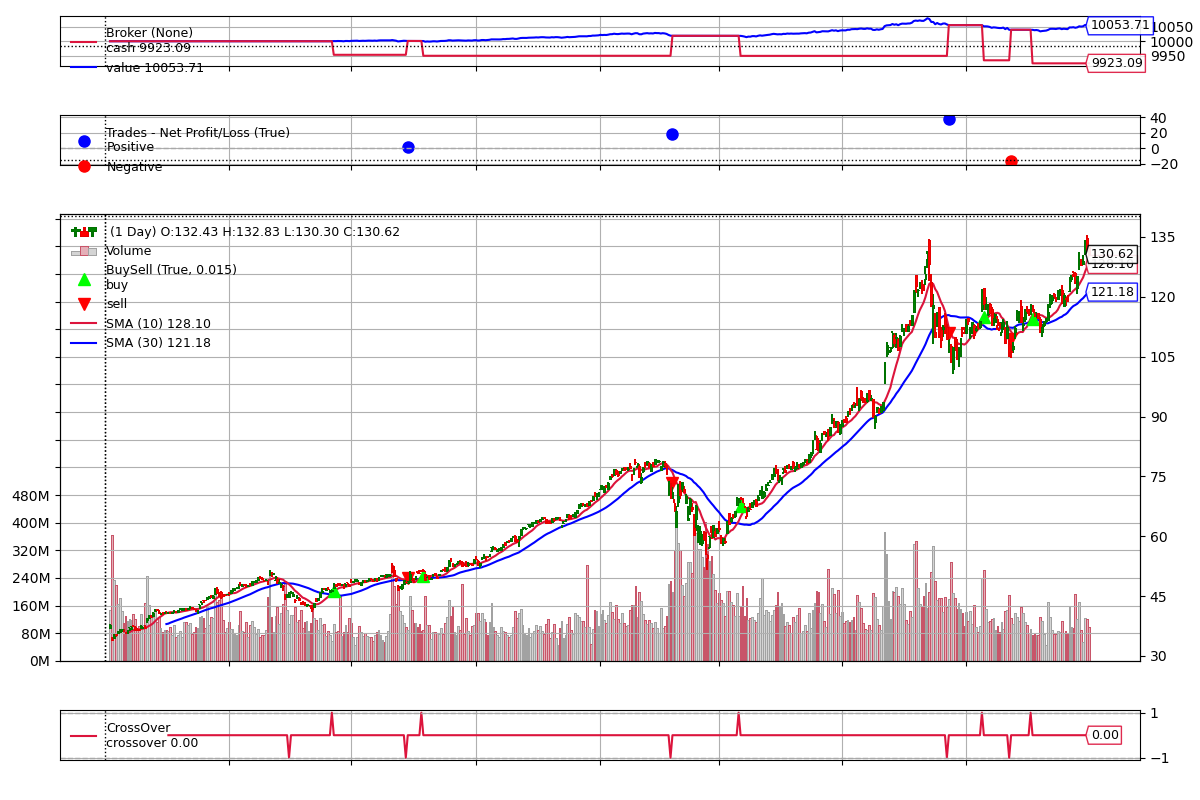

In [12]:
import backtrader as bt
import datetime
import pandas as pd
import yfinance as yf
from IPython.display import Image

class SimpleStrategy(bt.Strategy):
    params = (('sma_period', 50),)
    
    def __init__(self):
        self.sma = bt.indicators.SMA(self.data.close, period=self.params.sma_period)
        self.order = None
    
    def next(self):
        if self.order:
            return
            
        if not self.position:
            if self.data.close[0] > self.sma[0]:
                # Buy with fixed position size
                size = int(self.broker.getcash() * 0.95 / self.data.close[0])
                self.order = self.buy(size=size)
        else:
            if self.data.close[0] < self.sma[0]:
                self.order = self.sell()

# Main backtest function
def run_simple_backtest(ticker='SPY', start_date='2023-01-01', end_date='2025-03-15'):
    cerebro = bt.Cerebro(stdstats=True)
    cerebro.broker.set_cash(10000.0)
    cerebro.broker.setcommission(commission=0.001)
    
    # Disable margin trading
    cerebro.broker.set_checksubmit(False)
    
    # Download data
    data_df = yf.download(ticker, start=start_date, end=end_date)
    data_df.columns = [col[0].lower() for col in data_df.columns]
    data = bt.feeds.PandasData(dataname=data_df)
    cerebro.adddata(data)
    
    cerebro.addstrategy(SimpleStrategy)
    
    print(f'Starting Portfolio Value: ${cerebro.broker.getvalue():.2f}')
    cerebro.run()
    print(f'Final Portfolio Value: ${cerebro.broker.getvalue():.2f}')
    
    return cerebro

# Test simple strategy
if __name__ == "__main__":
    cerebro = run_simple_backtest(ticker='SPY')
    cerebro.plot(style='candlestick')
    
    display(Image('temp_bt_plot.png'))